# VAE WITH COMET

In [23]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
from comet_ml import Experiment
import os
import numpy as np

## PREPARE MNIST DATA

In [24]:
batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.Lambda(lambda x: x.view(-1) - 0.5),
    v2.Lambda(lambda x: x.view(-1))
])

# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

## VAE

### VARIATIONAL ENCODER

In [25]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        
        self.fc1 = nn.Linear(in_features=input_dim, out_features=64)
        self.relu = nn.ReLU()
        # Layer for μ (mean vector of the latent distribution)
        self.fc2 = nn.Linear(64, latent_dim)
        # Layer for σ (deviation)
        self.fc3 = nn.Linear(64, latent_dim)

        #Normal distribution
        self.N = torch.distributions.Normal(0,1)

    def forward(self, x):
        x = self.relu(self.fc1(x))

        # Środek (średnia) wektora latent dla próbki
        mu = self.fc2(x)
        
        # Logarytm odchylenia standardowego wektora latent
        log_sigma = self.fc3(x)
        # Odchylenie standardowe (sigma) – zapewniamy, że wartości są dodatnie
        sigma = torch.exp(log_sigma)

        # Random sample from N(0,1)
        epsilon = torch.randn_like(mu)

        # Final latent (sigma * epsilon to rozciągnięcie randomowego sampla na odchylenie standardowe)
        z = mu + sigma * epsilon

        # KL Divergence (jak odbiega z(mu,sigma) od N(0,1))
        KL =  0.5 * torch.sum(sigma**2 + mu**2 - 2*log_sigma - 1)

        return z, KL


### DECODER

In [26]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(in_features=latent_dim, out_features=64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=64, out_features=output_dim)

    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z

### VAE

In [27]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(VAE, self).__init__()

        self.Encoder = VariationalEncoder(input_dim = input_dim, latent_dim=latent_dim)
        self.Decoder = Decoder(latent_dim=latent_dim, output_dim=output_dim)

    def forward(self, x):
        z, KL = self.Encoder(x) 
        reconstructed = self.Decoder(z)
        return reconstructed, KL

## COMET ML SETUP

In [28]:
# Initialize Comet.ml experiment
experiment = Experiment(
    api_key=os.getenv("COMET_API_KEY"),
    project_name="Lo-Fi generator",
)

experiment.set_name("VAE with reconstruction loss + KL")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : VAE with reconstruction loss + KL
COMET INFO:     url                   : https://www.comet.com/ziemmi13/lo-fi-generator/4dec2740f7674a8ebd4a10f7daa383a7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     KL [17]                       : (4.191384792327881, 715.6959838867188)
COMET INFO:     epoch_KL [3]                  : (382.824334703783, 616.1348503159562)
COMET INFO:     epoch_reconstruction_loss [3] : (5201.969113347881, 6947.646078341551)
COMET INFO:     epoch_train_loss [3]          : (5589.484015816564, 7563.780928296575)
COMET INF

## LOSS FUNCTION

In [29]:
def vae_loss(x, reconstructed_x, KL, loss_type):
    # Reconstruction loss
    if loss_type == "BCE":
        reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    elif loss_type == "MSE":
        reconstruction_loss = (((reconstructed_x - x)**2)**1/2).sum()
    
    full_loss = reconstruction_loss + KL
    return full_loss, reconstruction_loss

## MODEL PARAMETERS

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=28*28, latent_dim=2, output_dim=28*28).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = vae_loss
num_epochs = 10

In [31]:
print(model)

VAE(
  (Encoder): VariationalEncoder(
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=64, out_features=2, bias=True)
    (fc3): Linear(in_features=64, out_features=2, bias=True)
  )
  (Decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=64, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=64, out_features=784, bias=True)
  )
)


## TRAINING

In [32]:
def train(device, model, train_loader, val_loader, optimizer, num_epochs, scheduler, resume_path=None, early_stopping_patience=5):
    model.to(device)

    for epoch in range(num_epochs):
        #Training phase
        model.train()
        train_loss = 0
        train_reconstruction_loss = 0
        train_KL = 0
        for batch_idx, batch in enumerate(train_loader):
            images, _ = batch
            images = images.to(device)
            optimizer.zero_grad()
            reconstructed_images, KL = model(images)
            loss, reconstruction_loss = loss_fn(images, reconstructed_images, KL, loss_type="MSE")
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_reconstruction_loss += reconstruction_loss.item()
            train_KL += KL.item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch + 1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                experiment.log_metric("train_loss", loss.item(), step=epoch * len(train_loader) + batch_idx)
                experiment.log_metric("reconstruction_loss", reconstruction_loss.item(), step=epoch * len(train_loader) + batch_idx)
                experiment.log_metric("KL", KL.item(), step=epoch * len(train_loader) + batch_idx)

        epoch_loss = train_loss / len(train_loader)
        epoch_reconstruction_loss = train_reconstruction_loss / len(train_loader)
        epoch_KL = train_KL / len(train_loader)
        # Log epoch metrics
        experiment.log_metric("epoch_train_loss", epoch_loss, step=epoch)
        experiment.log_metric("epoch_reconstruction_loss", epoch_reconstruction_loss, step=epoch)
        experiment.log_metric("epoch_KL", epoch_KL, step=epoch)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0
            for batch_idx, batch in enumerate(val_loader):
                images, _ = batch
                images = images.to(device)
                optimizer.zero_grad()
                reconstructed_images, KL = model(images)
                loss = loss_fn(images, reconstructed_images, KL, loss_type="MSE")
                loss.backward()
                optimizer.step()
                val_loss += loss.item()

            val_epoch_loss = val_loss / len(val_loader.dataset) 
            print(f'Epoch [{epoch + 1}/{num_epochs}]')
            print(f'Training Loss: {epoch_loss:.4f}')
            print(f'Validation Loss: {val_epoch_loss:.4f}')
            print('-' * 60)

            # Log validation metrics
            experiment.log_metric("val_loss", val_epoch_loss, step=epoch)


In [33]:
train(device=device, model=model, train_loader=train_loader, val_loader=None, optimizer=optimizer, num_epochs=20, scheduler=None)

Epoch: 1, Batch: 0, Loss: 11878.1387
Epoch: 1, Batch: 100, Loss: 3832.6284
Epoch: 1, Batch: 200, Loss: 3551.4639
Epoch: 1, Batch: 300, Loss: 3425.8682
Epoch: 1, Batch: 400, Loss: 3200.1060
Epoch: 2, Batch: 0, Loss: 3132.9551
Epoch: 2, Batch: 100, Loss: 3215.6538
Epoch: 2, Batch: 200, Loss: 2971.0693
Epoch: 2, Batch: 300, Loss: 3161.1436
Epoch: 2, Batch: 400, Loss: 2955.5193
Epoch: 3, Batch: 0, Loss: 2915.1843
Epoch: 3, Batch: 100, Loss: 2910.2104
Epoch: 3, Batch: 200, Loss: 2854.8093
Epoch: 3, Batch: 300, Loss: 2998.7778
Epoch: 3, Batch: 400, Loss: 2954.8389
Epoch: 4, Batch: 0, Loss: 2962.0259
Epoch: 4, Batch: 100, Loss: 2854.4529
Epoch: 4, Batch: 200, Loss: 2918.6865
Epoch: 4, Batch: 300, Loss: 2904.6841
Epoch: 4, Batch: 400, Loss: 3080.4766
Epoch: 5, Batch: 0, Loss: 2995.2820
Epoch: 5, Batch: 100, Loss: 3021.6226
Epoch: 5, Batch: 200, Loss: 3029.0039
Epoch: 5, Batch: 300, Loss: 3015.2305
Epoch: 5, Batch: 400, Loss: 2870.1738
Epoch: 6, Batch: 0, Loss: 2941.3887
Epoch: 6, Batch: 100, L

#### VAE LATENT SPACE

In [34]:
plot_latent(model, train_loader)

NameError: name 'plot_latent' is not defined

#### VAE RESULTS

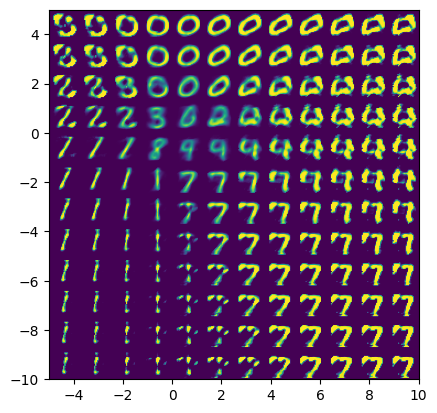

In [ ]:
plot_reconstructed(model)

## END EXPERIMENT

In [ ]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Test VAE
COMET INFO:     url                   : https://www.comet.com/ziemmi13/lo-fi-generator/88d4b1a5c7164c849ff546de5360e2bf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch_train_loss [20] : (5083.027326051106, 7651.783685159581)
COMET INFO:     train_loss [100]      : (4745.3486328125, 23811.564453125)
COMET INFO:   Others:
COMET INFO:     Name : Test VAE
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged autom